# Locality Sensitive Hashing

Locality Sensitive Hashing (LSH) provides for a fast, efficient approximate nearest neighbor search. The algorithm scales well with respect to the number of data points as well as dimensions.

In this assignment, you will
* Implement the LSH algorithm for approximate nearest neighbor search
* Examine the accuracy for different documents by comparing against brute force search, and also contrast runtimes
* Explore the role of the algorithm’s tuning parameters in the accuracy of the method

## Import necessary packages

In [1]:
import numpy as np
import turicreate
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import pairwise_distances
import time
from copy import copy
import matplotlib.pyplot as plt
%matplotlib inline

'''compute norm of a sparse vector
   Thanks to: Jaiyam Sharma'''
def norm(x):
    sum_sq = x.dot(x.T)
    norm = np.sqrt(sum_sq)
    return(norm)

## Load in the Wikipedia dataset

In [2]:
wiki = turicreate.SFrame('people_wiki.sframe/')

In [3]:
wiki

URI,name,text
<http://dbpedia.org/resource/Digby_Morrell> ...,Digby Morrell,digby morrell born 10october 1979 is a former ...
<http://dbpedia.org/resource/Alfred_J._Lewy> ...,Alfred J. Lewy,alfred j lewy aka sandylewy graduated from ...
<http://dbpedia.org/resource/Harpdog_Brown> ...,Harpdog Brown,harpdog brown is a singerand harmonica player who ...
<http://dbpedia.org/resource/Franz_Rottensteiner> ...,Franz Rottensteiner,franz rottensteiner bornin waidmannsfeld lower ...
<http://dbpedia.org/resource/G-Enka> ...,G-Enka,henry krvits born 30december 1974 in tallinn ...
<http://dbpedia.org/resource/Sam_Henderson> ...,Sam Henderson,sam henderson bornoctober 18 1969 is an ...
<http://dbpedia.org/resource/Aaron_LaCrate> ...,Aaron LaCrate,aaron lacrate is anamerican music producer ...
<http://dbpedia.org/resource/Trevor_Ferguson> ...,Trevor Ferguson,trevor ferguson aka johnfarrow born 11 november ...
<http://dbpedia.org/resource/Grant_Nelson> ...,Grant Nelson,grant nelson born 27april 1971 in london ...
<http://dbpedia.org/resource/Cathy_Caruth> ...,Cathy Caruth,cathy caruth born 1955 isfrank h t rhodes ...


For this assignment, let us assign a unique ID to each document.

In [4]:
wiki = wiki.add_row_number()

## Extract TF-IDF matrix

We first use Turi Create to compute a TF-IDF representation for each document.

In [5]:
wiki['tf_idf'] = turicreate.text_analytics.tf_idf(wiki['text'])
wiki.head()

id,URI,name,text,tf_idf
0,<http://dbpedia.org/resource/Digby_Morrell> ...,Digby Morrell,digby morrell born 10october 1979 is a former ...,"{'melbourne':3.8914310119380633, ..."
1,<http://dbpedia.org/resource/Alfred_J._Lewy> ...,Alfred J. Lewy,alfred j lewy aka sandylewy graduated from ...,"{'time':1.3253342074200498, ..."
2,<http://dbpedia.org/resource/Harpdog_Brown> ...,Harpdog Brown,harpdog brown is a singerand harmonica player who ...,"{'society':2.4448047262085693, ..."
3,<http://dbpedia.org/resource/Franz_Rottensteiner> ...,Franz Rottensteiner,franz rottensteiner bornin waidmannsfeld lower ...,"{'kurdlawitzpreis':10.986495389225194, ..."
4,<http://dbpedia.org/resource/G-Enka> ...,G-Enka,henry krvits born 30december 1974 in tallinn ...,"{'curtis':5.299520032885375, ..."
5,<http://dbpedia.org/resource/Sam_Henderson> ...,Sam Henderson,sam henderson bornoctober 18 1969 is an ...,"{'asses':9.600201028105303, 's ..."
6,<http://dbpedia.org/resource/Aaron_LaCrate> ...,Aaron LaCrate,aaron lacrate is anamerican music producer ...,"{'streamz':10.986495389225194, ..."
7,<http://dbpedia.org/resource/Trevor_Ferguson> ...,Trevor Ferguson,trevor ferguson aka johnfarrow born 11 november ...,"{'concordia':6.250296940830698, ..."
8,<http://dbpedia.org/resource/Grant_Nelson> ...,Grant Nelson,grant nelson born 27april 1971 in london ...,"{'heavies':8.907053847545358, 'n ..."
9,<http://dbpedia.org/resource/Cathy_Caruth> ...,Cathy Caruth,cathy caruth born 1955 isfrank h t rhodes ...,"{'2002':1.8753125887822302, ..."


For the remainder of the assignment, we will use sparse matrices. Sparse matrices are matrices) that have a small number of nonzero entries. A good data structure for sparse matrices would only store the nonzero entries to save space and speed up computation. SciPy provides a highly-optimized library for sparse matrices. Many matrix operations available for NumPy arrays are also available for SciPy sparse matrices.We first convert the TF-IDF column (in dictionary format) into the SciPy sparse matrix format.

In [6]:
def sframe_to_scipy(x, column_name):
    '''
    Convert a dictionary column of an SFrame into a sparse matrix format where
    each (row_id, column_id, value) triple corresponds to the value of
    x[row_id][column_id], where column_id is a key in the dictionary.
       
    Example
    >>> sparse_matrix, map_key_to_index = sframe_to_scipy(sframe, column_name)
    '''
    assert type(x[column_name][0]) == dict, 'The chosen column must be dict type, representing sparse data.'
    
    # Stack will transform x to have a row for each unique (row, key) pair.
    x = x.stack(column_name, ['feature', 'value'])
    
    # Map feature words to integers 
    unique_words = sorted(x['feature'].unique())
    mapping = {word:i for i, word in enumerate(unique_words)}
    x['feature_id'] = x['feature'].apply(lambda x: mapping[x])
    
    # Create numpy arrays that contain the data for the sparse matrix.
    row_id = np.array(x['id'])
    col_id = np.array(x['feature_id'])
    data = np.array(x['value'])
    
    width = x['id'].max() + 1
    height = x['feature_id'].max() + 1
    
    # Create a sparse matrix.
    mat = csr_matrix((data, (row_id, col_id)), shape=(width, height))
    return mat, mapping

In [7]:
%%time
corpus, mapping = sframe_to_scipy(wiki, 'tf_idf')

CPU times: user 2min 55s, sys: 4.47 s, total: 2min 59s
Wall time: 1min 15s


In [8]:
assert corpus.shape == (59071, 547979)
print('Check passed correctly!')

Check passed correctly!


## Train an LSH model

The idea behind LSH is to translate the sign of our tf-idf scores into a binary index (1 or 0) by using seeing if our score falls above or below a randomly defined line. This <a href="http://ethen8181.github.io/machine-learning/recsys/content_based/lsh_text.html">link</a> is helpful for understanding LSH and our code in more detail.


LSH performs an efficient neighbor search by randomly partitioning all reference data points into different bins. Today we will build a popular variant of LSH known as <strong>random binary projection</strong>, which approximates cosine distance. There are other variants we could use for other choices of distance metrics.

The first step is to generate a collection of random vectors from the standard Gaussian distribution.

In [9]:
def generate_random_vectors(dim, n_vectors):
    return np.random.randn(dim, n_vectors)

To visualize these Gaussian random vectors, let's look at an example in low-dimensions.  Below, we generate 3 random vectors each of dimension 5.

In [10]:
# Generate 3 random vectors of dimension 5, arranged into a single 5 x 3 matrix.
generate_random_vectors(n_vectors=3, dim=5)

array([[-0.59190684, -0.04695486,  0.08649027],
       [-1.49748067,  0.56637402,  0.1280583 ],
       [-1.0103791 ,  0.43304302, -0.5724193 ],
       [-0.41829635,  0.3852098 ,  0.85029414],
       [-0.72095186,  1.26088   , -1.72306299]])

We now generate random vectors of the same dimensionality as our vocubulary size (547979).  Each vector can be used to compute one bit in the bin encoding.  We generate 16 vectors, leading to a 16-bit encoding of the bin index for each document.

In [11]:
# Generate 16 random vectors of dimension 547979
np.random.seed(0)
n_vectors = 16    # columns
random_vectors = generate_random_vectors(corpus.shape[1], n_vectors)
random_vectors.shape

(547979, 16)

Next, we partition data points into bins. Instead of using explicit loops, we'd like to utilize matrix operations for greater efficiency. Let's walk through the construction step by step.

We'd like to decide which bin document 0 should go. Since 16 random vectors were generated in the previous cell, we have 16 bits to represent the bin index. The first bit is given by the sign of the dot product between the first random vector and the document's TF-IDF vector.

In [12]:
sample = corpus[0] # vector of tf-idf values for document 0
bin_indices_bits = sample.dot(random_vectors[:,0]) >= 0
bin_indices_bits

array([ True])

In [13]:
sample

<1x547979 sparse matrix of type '<class 'numpy.float64'>'
	with 139 stored elements in Compressed Sparse Row format>

Similarly, the second bit is computed as the sign of the dot product between the second random vector and the document vector.

In [14]:
sample.dot(random_vectors[:, 1]) >= 0 # True if positive sign; False if negative sign

array([False])

We can compute all of the bin index bits at once as follows. Note the absence of the explicit `for` loop over the 16 vectors. Matrix operations let us batch dot-product computation in a highly efficent manner, unlike the `for` loop construction. Given the relative inefficiency of loops in Python, the advantage of matrix operations is even greater.

In [15]:
sample.dot(random_vectors) >= 0 # should return an array of 16 True/False bits

array([[ True, False, False, False,  True, False,  True, False,  True,
         True,  True, False,  True,  True, False,  True]])

In [16]:
np.array(sample.dot(random_vectors) >= 0, dtype=int) # display index bits in 0/1's

array([[1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1]])

All documents that obtain exactly this vector will be assigned to the same bin. We'd like to repeat the identical operation on all documents in the Wikipedia dataset and compute the corresponding bin indices. Again, we use matrix operations  so that no explicit loop is needed.

In [17]:
corpus[0:2].dot(random_vectors) >= 0 # compute bit indices of first two documents

array([[ True, False, False, False,  True, False,  True, False,  True,
         True,  True, False,  True,  True, False,  True],
       [False, False, False, False,  True, False, False, False,  True,
         True,  True, False, False,  True, False,  True]])

In [18]:
corpus.dot(random_vectors) >= 0 # compute bit indices of ALL documents

array([[ True, False, False, ...,  True, False,  True],
       [False, False, False, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False,  True],
       [ True,  True, False, ...,  True,  True, False],
       [ True,  True,  True, ...,  True, False,  True]])

We're almost done! To make it convenient to refer to individual bins, we convert each binary bin index into a single integer: 
```
Bin index                      integer
[0,0,0,0,0,0,0,0,0,0,0,0]   => 0
[0,0,0,0,0,0,0,0,0,0,0,1]   => 1
[0,0,0,0,0,0,0,0,0,0,1,0]   => 2
[0,0,0,0,0,0,0,0,0,0,1,1]   => 3
...
[1,1,1,1,1,1,1,1,1,1,0,0]   => 65532
[1,1,1,1,1,1,1,1,1,1,0,1]   => 65533
[1,1,1,1,1,1,1,1,1,1,1,0]   => 65534
[1,1,1,1,1,1,1,1,1,1,1,1]   => 65535 (= 2^16-1)
```
By the [rules of binary number representation](https://en.wikipedia.org/wiki/Binary_number#Decimal), we just need to compute the dot product between the document vector and the vector consisting of powers of 2:

In [19]:
index_bits = (sample.dot(random_vectors) >= 0)
powers_of_two = (1 << np.arange(15, -1, -1))
print(index_bits)
print(powers_of_two)
print(index_bits.dot(powers_of_two))

[[ True False False False  True False  True False  True  True  True False
   True  True False  True]]
[32768 16384  8192  4096  2048  1024   512   256   128    64    32    16
     8     4     2     1]
[35565]


Since it's the dot product again, we batch it with a matrix operation:

In [20]:
index_bits = sample.dot(random_vectors) >= 0
index_bits.dot(powers_of_two)

array([35565])

This array gives us the integer index of the bins for all documents.

Now we are ready to complete the following function. Given the integer bin indices for the documents, you should compile a list of document IDs that belong to each bin. Since a list is to be maintained for each unique bin index, a dictionary of lists is used.

1. Compute the integer bin indices. This step is already completed.
2. For each document in the dataset, do the following:
   * Get the integer bin index for the document.
   * Fetch the list of document ids associated with the bin; if no list yet exists for this bin, assign the bin an empty list.
   * Add the document id to the end of the list.


In [21]:
from collections import defaultdict 

def train_lsh(data, n_vectors, seed=None):    
    if seed is not None:
        np.random.seed(seed)

    dim = data.shape[1]
    random_vectors = generate_random_vectors(dim, n_vectors)  

    # Partition data points into bins,
    # and encode bin index bits into integers
    bin_indices_bits = data.dot(random_vectors) >= 0
    powers_of_two = 1 << np.arange(n_vectors - 1, -1, step=-1)
    bin_indices = bin_indices_bits.dot(powers_of_two)

    # Update `table` so that `table[i]` is the list of document ids with bin index equal to i
    table = defaultdict(list)
    for idx, bin_index in enumerate(bin_indices):
        # Fetch the list of document ids associated with the bin and add the document id to the end.
        # data_index: document ids
        table[bin_index] = []
        # append() will add a list of document ids to table dict() with key as bin_index
        table[bin_index].append(idx)
            
    # Note that we're storing the bin_indices here
    # so we can do some ad-hoc checking with it,
    # this isn't actually required
    model = {'data': data,
             'table': table,
             'random_vectors': random_vectors,
             'bin_indices': bin_indices,
             'bin_indices_bits': bin_indices_bits}
    return model

**Checkpoint**. 

In [22]:
def compare_bits(model, id_1, id_2):
    bits1 = model['bin_indices_bits'][id_1]
    bits2 = model['bin_indices_bits'][id_2]
    print('Number of agreed bits: ', np.sum(bits1 == bits2))
    return np.sum(bits1 == bits2)

In [23]:
model = train_lsh(corpus, 16, seed=475)
obama_id = wiki[wiki['name'] == 'Barack Obama']['id'][0]
biden_id = wiki[wiki['name'] == 'Joe Biden']['id'][0]
similariy = compare_bits(model, obama_id, biden_id)

Number of agreed bits:  15


**Note.** We will be using the model trained here in the following sections, unless otherwise indicated.

## Inspect bins

After generating our LSH model, let's examine the generated bins to get a deeper understanding of them. Here, we will look at these similar products' bins to see if the result matches intuition. Remember the idea behind LSH is that similar data points will tend to fall into nearby bins.

In [24]:
# This function will help us get similar items, given the id
def get_similarity_items(X_tfidf, item_id, topn=5):
    """
    Get the top similar items for a given item id.
    The similarity measure here is based on cosine distance.
    """
    query = X_tfidf[item_id]
    scores = X_tfidf.dot(query.T).toarray().ravel()
    best = np.argpartition(scores, -topn)[-topn:]
    similar_items = sorted(zip(best, scores[best]), key=lambda x: -x[1])
    similar_item_ids = [similar_item for similar_item, _ in similar_items]
    print("Similar items to id: {}".format(item_id))
    for _id in similar_item_ids:
        print(wiki[_id]['name'])
    print('\n')
    return similar_item_ids

Let us look at some documents and see which bins they fall into.

In [25]:
wiki[wiki['name'] == 'Barack Obama']

id,URI,name,text,tf_idf
35817,<http://dbpedia.org/resource/Barack_Obama> ...,Barack Obama,barack hussein obama iibrk husen bm born august ...,"{'normalize':10.293348208665249, ..."


**Quiz Question**. What is the document `id` of Barack Obama's article?

**Quiz Question**. Which bin contains Barack Obama's article? Enter its integer index.

In [26]:
wiki[wiki['name'] == 'Barack Obama']['id'][0]

35817

In [27]:
# bin_index containing Barack Obama's article
print(model['bin_indices'][35817])

38448


Recall from the previous assignment that Joe Biden was a close neighbor of Barack Obama.

In [28]:
wiki[wiki['name'] == 'Joe Biden']

id,URI,name,text,tf_idf
24478,<http://dbpedia.org/resource/Joe_Biden> ...,Joe Biden,joseph robinette joebiden jr dosf rbnt badn ...,"{'were':1.521978023354629, ..."


**Quiz Question**. Examine the bit representations of the bins containing Barack Obama and Joe Biden. In how many places do they agree?

1. 16 out of 16 places (Barack Obama and Joe Biden fall into the same bin)
2. 15 out of 16 places
3. 13 out of 16 places
4. 11 out of 16 places
5. 9 out of 16 places

In [29]:
wiki[wiki['name'] == 'Joe Biden']['id'][0]

24478

In [30]:
# bin_index of Joe Biden
print(np.array(model['bin_indices_bits'][24478], dtype=int)) # list of 0/1's

# bit representations of the bins containing Joe Biden
print(model['bin_indices'][24478]) # integer format

[1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0]
37424


In [31]:
model['bin_indices_bits'][35817] == model['bin_indices_bits'][24478]

array([ True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [32]:
# sum of bits agree between Barack Obama and Joe Biden
sum(model['bin_indices_bits'][35817] == model['bin_indices_bits'][24478])

15

Compare the result with a former British diplomat

In [33]:
jones_id = wiki[wiki['name']=='Wynn Normington Hugh-Jones']['id'][0]
compare_bits(model, obama_id, jones_id)

Number of agreed bits:  8


8

How about the documents in the same bin as Barack Obama? Are they necessarily more similar to Obama than Biden?  Let's look at which documents are in the same bin as the Barack Obama article.

In [34]:
model['table'][model['bin_indices'][35817]]

[54743]

There is one more document in the same bin. Which document is it?

In [35]:
doc_ids = list(model['table'][model['bin_indices'][35817]])
doc_ids.remove(35817) # display documents other than Obama

docs = wiki.filter_by(values=doc_ids, column_name='id') # filter by id column
docs

ValueError: list.remove(x): x not in list

In [36]:
res = compare_bits(model, obama_id, docs[0]['id']), compare_bits(model, obama_id, biden_id)

NameError: name 'docs' is not defined

**In summary**, similar data points will in general _tend to_ fall into _nearby_ bins, but that's all we can say about LSH. In a high-dimensional space such as text features, we often get unlucky with our selection of only a few random vectors such that dissimilar data points go into the same bin while similar data points fall into different bins. **Given a query document, we must consider all documents in the nearby bins and sort them according to their actual distances from the query.**

## Query the LSH model

Let us first implement the logic for searching nearby neighbors, which goes like this:
```
1. Let L be the bit representation of the bin that contains the query documents.
2. Consider all documents in bin L.
3. Consider documents in the bins whose bit representation differs from L by 1 bit.
4. Consider documents in the bins whose bit representation differs from L by 2 bits.
...
```

To obtain candidate bins that differ from the query bin by some number of bits, we use `itertools.combinations`, which produces all possible subsets of a given list. See [this documentation](https://docs.python.org/3/library/itertools.html#itertools.combinations) for details.
```
1. Decide on the search radius r. This will determine the number of different bits between the two vectors.
2. For each subset (n_1, n_2, ..., n_r) of the list [0, 1, 2, ..., num_vector-1], do the following:
   * Flip the bits (n_1, n_2, ..., n_r) of the query bin to produce a new bit vector.
   * Fetch the list of documents belonging to the bin indexed by the new bit vector.
   * Add those documents to the candidate set.
```

Each line of output from the following cell is a 3-tuple indicating where the candidate bin would differ from the query bin. For instance,
```
(0, 1, 3)
```
indicates that the candiate bin differs from the query bin in first, second, and fourth bits.

In [37]:
from itertools import combinations

In [40]:
num_vector = 16
search_radius = 3

for diff in combinations(range(num_vector), search_radius):
    print(diff)

(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 1, 5)
(0, 1, 6)
(0, 1, 7)
(0, 1, 8)
(0, 1, 9)
(0, 1, 10)
(0, 1, 11)
(0, 1, 12)
(0, 1, 13)
(0, 1, 14)
(0, 1, 15)
(0, 2, 3)
(0, 2, 4)
(0, 2, 5)
(0, 2, 6)
(0, 2, 7)
(0, 2, 8)
(0, 2, 9)
(0, 2, 10)
(0, 2, 11)
(0, 2, 12)
(0, 2, 13)
(0, 2, 14)
(0, 2, 15)
(0, 3, 4)
(0, 3, 5)
(0, 3, 6)
(0, 3, 7)
(0, 3, 8)
(0, 3, 9)
(0, 3, 10)
(0, 3, 11)
(0, 3, 12)
(0, 3, 13)
(0, 3, 14)
(0, 3, 15)
(0, 4, 5)
(0, 4, 6)
(0, 4, 7)
(0, 4, 8)
(0, 4, 9)
(0, 4, 10)
(0, 4, 11)
(0, 4, 12)
(0, 4, 13)
(0, 4, 14)
(0, 4, 15)
(0, 5, 6)
(0, 5, 7)
(0, 5, 8)
(0, 5, 9)
(0, 5, 10)
(0, 5, 11)
(0, 5, 12)
(0, 5, 13)
(0, 5, 14)
(0, 5, 15)
(0, 6, 7)
(0, 6, 8)
(0, 6, 9)
(0, 6, 10)
(0, 6, 11)
(0, 6, 12)
(0, 6, 13)
(0, 6, 14)
(0, 6, 15)
(0, 7, 8)
(0, 7, 9)
(0, 7, 10)
(0, 7, 11)
(0, 7, 12)
(0, 7, 13)
(0, 7, 14)
(0, 7, 15)
(0, 8, 9)
(0, 8, 10)
(0, 8, 11)
(0, 8, 12)
(0, 8, 13)
(0, 8, 14)
(0, 8, 15)
(0, 9, 10)
(0, 9, 11)
(0, 9, 12)
(0, 9, 13)
(0, 9, 14)
(0, 9, 15)
(0, 10, 11)
(0, 10, 12)
(0, 10, 13)
(0, 10, 14

With this output in mind, implement the logic for nearby bin search:

In [42]:
def search_nearby_bins(query_bin_bits, table, search_radius=2, initial_candidates=set()):
    """
    For a given query vector and trained LSH model, return all candidate neighbors for
    the query among all bins within the given search radius.
    
    Example usage
    -------------
    >>> model = train_lsh(corpus, num_vector=16, seed=143)
    >>> q = model['bin_index_bits'][0]  # vector for the first document
  
    >>> candidates = search_nearby_bins(q, model['table'])
    """
    num_vector = len(query_bin_bits)
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
    
    # Allow the user to provide an initial set of candidates.
    candidate_set = copy(initial_candidates)
    
    for different_bits in combinations(range(num_vector), search_radius):       
        # Flip the bits (n_1,n_2,...,n_r) of the query bin to produce a new bit vector.
        ## Hint: you can iterate over a tuple like a list
        alternate_bits = copy(query_bin_bits)
        for i in different_bits:
            alternate_bits[i] = ~alternate_bits[i] # YOUR CODE HERE 
        
        # Convert the new bit vector to an integer index
        nearby_bin = alternate_bits.dot(powers_of_two)
        
        # Fetch the list of documents belonging to the bin indexed by the new bit vector.
        # Then add those documents to candidate_set
        # Make sure that the bin exists in the table!
        # Hint: update() method for sets lets you add an entire list to the set
        if nearby_bin in table:
            more_docs = table[nearby_bin] # Get all document_ids of the bin
            candidate_set.update(more_docs) # YOUR CODE HERE: Update candidate_set with the documents in this bin.
            
    return candidate_set

**Checkpoint**. Running the function with `search_radius=0` should yield the list of documents belonging to the same bin as the query.

In [45]:
obama_bin_index = model['bin_indices_bits'][35817] # bin index of Barack Obama
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=0)
if candidate_set == set({35817, 54743}):
    print('Passed test')
else:
    print('Check your code')
print('List of documents in the same bin as Obama: {}'.format(candidate_set))

Check your code
List of documents in the same bin as Obama: {54743}


**Checkpoint**. Running the function with `search_radius=1` adds more documents to the fore.

In [46]:
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=1, initial_candidates=candidate_set)
if candidate_set == set({42243, 28804, 1810, 48919, 24478, 31010, 7331, 23716, 51108, 48040, 36266, 33200, 25023, 23617, 54743, 34910, 35817, 34159, 14451, 23926, 39032, 12028, 43775}):
    print('Passed test')
else:
    print('Check your code')
print(candidate_set)

Check your code
{42243, 51108, 7331, 48040, 36266, 48919, 34159, 43775, 23926, 54743, 34910, 25023}


**Note**. Don't be surprised if few of the candidates look similar to Obama. This is why we add as many candidates as our computational budget allows and sort them by their distance to the query.

Now we have a function that can return all the candidates from neighboring bins. Next we write a function to collect all candidates and compute their true distance to the query.

In [47]:
def query(vec, model, k, max_search_radius):
  
    data = model['data']
    table = model['table']
    random_vectors = model['random_vectors']
    num_vector = random_vectors.shape[1]
    
    
    # Compute bin index for the query vector, in bit representation.
    bin_index_bits = (vec.dot(random_vectors) >= 0).flatten()
    
    # Search nearby bins and collect candidates
    candidate_set = set()
    for search_radius in range(max_search_radius+1):
        candidate_set = search_nearby_bins(bin_index_bits, table, search_radius, initial_candidates=candidate_set)
    
    # Sort candidates by their true distances from the query
    nearest_neighbors = turicreate.SFrame({'id':candidate_set})
    candidates = data[np.array(list(candidate_set)),:]
    nearest_neighbors['distance'] = pairwise_distances(candidates, vec, metric='cosine').flatten()
    
    return nearest_neighbors.topk('distance', k, reverse=True), len(candidate_set)

Let's try it out with Obama:

In [53]:
query(corpus[35817,:], model, k=10, max_search_radius=3)

(Columns:
 	id	int
 	distance	float
 
 Rows: 10
 
 Data:
 +-------+--------------------+
 |   id  |      distance      |
 +-------+--------------------+
 |  4032 | 0.8145547486714284 |
 | 43155 | 0.8408390074837325 |
 | 20159 | 0.844036884280093  |
 | 11517 | 0.8483420107162964 |
 | 22063 | 0.8946710479694914 |
 |  9051 | 0.9008406076426497 |
 | 55471 | 0.9060822276532203 |
 | 46253 | 0.9158128432084635 |
 | 21001 | 0.920508465468059  |
 | 42575 | 0.9222495100095367 |
 +-------+--------------------+
 [10 rows x 2 columns],
 452)

To identify the documents, it's helpful to join this table with the Wikipedia table:

In [54]:
query(corpus[35817,:], model, k=10, max_search_radius=3)[0].join(wiki[['id', 'name']], on='id').sort('distance')

id,distance,name
4032,0.8145547486714284,Kenneth D. Thompson
43155,0.8408390074837325,Goodwin Liu
20159,0.844036884280093,Charlie Crist
11517,0.8483420107162964,Louis Susman
22063,0.8946710479694914,Kathryn Troutman
9051,0.9008406076426497,Newt Gingrich
55471,0.9060822276532203,Gerry Maher
46253,0.9158128432084635,Francisco Rezek
21001,0.920508465468059,Monroe Price
42575,0.9222495100095367,Bob O'Donnell


We have shown that we have a working LSH implementation!

# Experimenting with your LSH implementation

In the following sections we have implemented a few experiments so that you can gain intuition for how your LSH implementation behaves in different situations. This will help you understand the effect of searching nearby bins and the performance of LSH versus computing nearest neighbors using a brute force search.

## Effect of nearby bin search

How does nearby bin search affect the outcome of LSH? There are three variables that are affected by the search radius:
* Number of candidate documents considered
* Query time
* Distance of approximate neighbors from the query

Let us run LSH multiple times, each with different radii for nearby bin search. We will measure the three variables as discussed above.

In [55]:
wiki[wiki['name']=='Barack Obama']

id,URI,name,text,tf_idf
35817,<http://dbpedia.org/resource/Barack_Obama> ...,Barack Obama,barack hussein obama iibrk husen bm born august ...,"{'normalize':10.293348208665249, ..."


In [56]:
%%time
num_candidates_history = []
query_time_history = []
max_distance_from_query_history = []
min_distance_from_query_history = []
average_distance_from_query_history = []

for max_search_radius in range(17):
    start=time.time()
    result, num_candidates = query(corpus[35817,:], model, k=10, max_search_radius=max_search_radius)
    end=time.time()
    query_time = end-start
    
    print('Radius:', max_search_radius)
    print(result.join(wiki[['id', 'name']], on='id').sort('distance'))
    
    average_distance_from_query = result['distance'][1:].mean()
    max_distance_from_query = result['distance'][1:].max()
    min_distance_from_query = result['distance'][1:].min()
    
    num_candidates_history.append(num_candidates)
    query_time_history.append(query_time)
    average_distance_from_query_history.append(average_distance_from_query)
    max_distance_from_query_history.append(max_distance_from_query)
    min_distance_from_query_history.append(min_distance_from_query)


Radius: 0
+-------+------------------+---------------------+
|   id  |     distance     |         name        |
+-------+------------------+---------------------+
| 54743 | 0.97334561058472 | Radovan %C5%BDerjav |
+-------+------------------+---------------------+
[1 rows x 3 columns]

Radius: 1
+-------+--------------------+------------------------------+
|   id  |      distance      |             name             |
+-------+--------------------+------------------------------+
| 34159 | 0.9430865736846581 |       Jennifer Hudson        |
| 23926 | 0.9608039657958866 | Se%C3%A1n Power (politician) |
| 36266 | 0.9615994281067699 |         Ralph Weber          |
| 54743 |  0.97334561058472  |     Radovan %C5%BDerjav      |
|  7331 | 0.9735542076945761 |       Joselo D%C3%ADaz       |
| 43775 | 0.9790856334914729 |       Carly Rae Jepsen       |
| 42243 | 0.9849819563329181 |          Matt Macri          |
| 51108 | 0.9876497805811162 |        Amorette Wild         |
| 48040 | 0.988732326

Radius: 11
+-------+--------------------+-------------------------------+
|   id  |      distance      |              name             |
+-------+--------------------+-------------------------------+
| 57108 | 0.7583583978869675 |     Hillary Rodham Clinton    |
| 38714 | 0.7705612276009974 |    Eric Stern (politician)    |
| 48693 | 0.8091922122931379 |          Artur Davis          |
|  4032 | 0.8145547486714284 |      Kenneth D. Thompson      |
| 14754 | 0.826854025896727  |          Mitt Romney          |
| 55044 | 0.8370132362812239 |          Wesley Clark         |
|  4845 | 0.8372605776442847 | Joe Walsh (Illinois politi... |
| 11394 | 0.8374590122927887 |          John G. Levi         |
| 47303 | 0.838152743883253  |           John Kerry          |
| 24848 | 0.8394067356676752 |        John C. Eastman        |
+-------+--------------------+-------------------------------+
[10 rows x 3 columns]

Radius: 12
+-------+--------------------+-------------------------------+
|   id  | 

Notice that the top 10 query results become more relevant as the search radius grows. Let's plot the three variables:

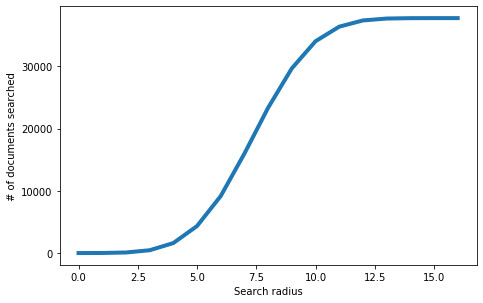

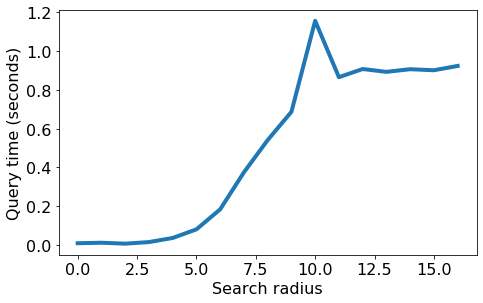

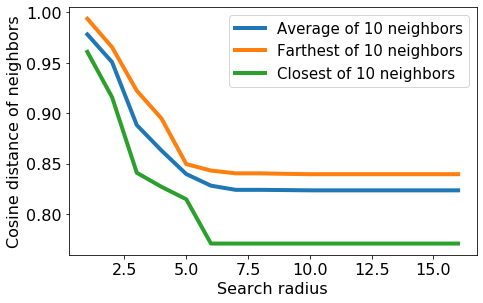

In [57]:
plt.figure(figsize=(7,4.5))
plt.plot(num_candidates_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('# of documents searched')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(query_time_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(average_distance_from_query_history, linewidth=4, label='Average of 10 neighbors')
plt.plot(max_distance_from_query_history, linewidth=4, label='Farthest of 10 neighbors')
plt.plot(min_distance_from_query_history, linewidth=4, label='Closest of 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance of neighbors')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

Some observations:
* As we increase the search radius, we find more neighbors that are a smaller distance away.
* With increased search radius comes a greater number documents that have to be searched. Query time is higher as a consequence.
* With sufficiently high search radius, the results of LSH begin to resemble the results of brute-force search.

**Quiz Question**. What was the smallest search radius that yielded the correct nearest neighbor, namely Joe Biden?

**Quiz Question**. Suppose our goal was to produce 10 approximate nearest neighbors whose average distance from the query document is within 0.01 of the average for the true 10 nearest neighbors. For Barack Obama, the true 10 nearest neighbors are on average about 0.77. What was the smallest search radius for Barack Obama that produced an average distance of 0.78 or better?

In [66]:
for i, v in enumerate(average_distance_from_query_history):
    if v <= 0.78:
        print(i, v)

TypeError: '<=' not supported between instances of 'NoneType' and 'float'

## Quality metrics for neighbors

The above analysis is limited by the fact that it was run with a single query, namely Barack Obama. We should repeat the analysis for the entirety of data. Iterating over all documents would take a long time, so let us randomly choose 10 documents for our analysis.

For each document, we first compute the true 25 nearest neighbors, and then run LSH multiple times. We look at two metrics:

* Precision@10: How many of the 10 neighbors given by LSH are among the true 25 nearest neighbors?
* Average cosine distance of the neighbors from the query

Then we run LSH multiple times with different search radii.

In [67]:
def brute_force_query(vec, data, k):
    num_data_points = data.shape[0]
    
    # Compute distances for ALL data points in training set
    nearest_neighbors = turicreate.SFrame({'id':range(num_data_points)})
    nearest_neighbors['distance'] = pairwise_distances(data, vec, metric='cosine').flatten()
    
    return nearest_neighbors.topk('distance', k, reverse=True)

The following cell will run LSH with multiple search radii and compute the quality metrics for each run. Allow a few minutes to complete.

In [68]:
%%time
max_radius = 17
precision = {i:[] for i in range(max_radius)}
average_distance  = {i:[] for i in range(max_radius)}
query_time  = {i:[] for i in range(max_radius)}

num_queries = 10
for i, ix in enumerate(np.random.choice(corpus.shape[0], num_queries, replace=False)):
    print('%s / %s' % (i, num_queries))
    ground_truth = set(brute_force_query(corpus[ix,:], corpus, k=25)['id'])
    # Get the set of 25 true nearest neighbors
    
    for r in range(1,max_radius):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=r)
        end = time.time()

        query_time[r].append(end-start)
        # precision = (# of neighbors both in result and ground_truth)/10.0
        precision[r].append(len(set(result['id']) & ground_truth)/10.0)
        average_distance[r].append(result['distance'][1:].mean())

0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
CPU times: user 1min 22s, sys: 2.15 s, total: 1min 24s
Wall time: 1min 23s


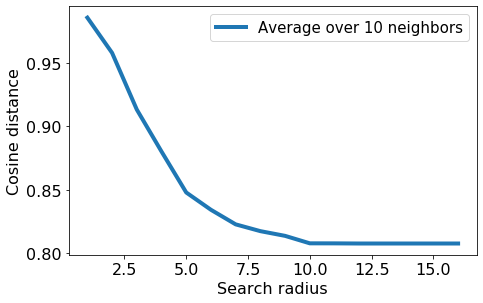

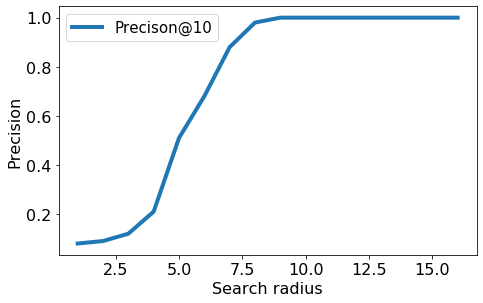

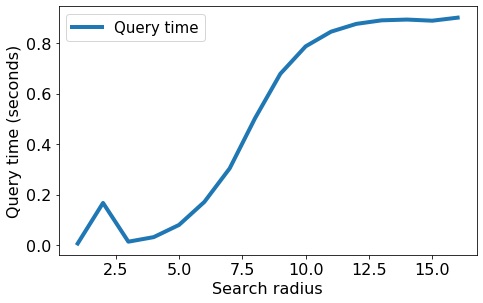

In [69]:
plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(average_distance[i]) for i in range(1,17)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(precision[i]) for i in range(1,17)], linewidth=4, label='Precison@10')
plt.xlabel('Search radius')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(query_time[i]) for i in range(1,17)], linewidth=4, label='Query time')
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

The observations for Barack Obama generalize to the entire dataset.

## Effect of number of random vectors

Let us now turn our focus to the remaining parameter: the number of random vectors. We run LSH with different number of random vectors, ranging from 5 to 20. We fix the search radius to 3.

Allow a few minutes for the following cell to complete.

In [70]:
precision = {i:[] for i in range(5,20)}
average_distance  = {i:[] for i in range(5,20)}
query_time = {i:[] for i in range(5,20)}
num_candidates_history = {i:[] for i in range(5,20)}
ground_truth = {}

num_queries = 10
docs = np.random.choice(corpus.shape[0], num_queries, replace=False)

for i, ix in enumerate(docs):
    ground_truth[ix] = set(brute_force_query(corpus[ix,:], corpus, k=25)['id'])
    # Get the set of 25 true nearest neighbors

for num_vector in range(5,20):
    print('num_vector = %s' % (num_vector))
    model = train_lsh(corpus, num_vector, seed=143)
    
    for i, ix in enumerate(docs):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=3)
        end = time.time()
        
        query_time[num_vector].append(end-start)
        precision[num_vector].append(len(set(result['id']) & ground_truth[ix])/10.0)
        average_distance[num_vector].append(result['distance'][1:].mean())
        num_candidates_history[num_vector].append(num_candidates)

num_vector = 5
num_vector = 6
num_vector = 7
num_vector = 8
num_vector = 9
num_vector = 10
num_vector = 11
num_vector = 12
num_vector = 13
num_vector = 14
num_vector = 15
num_vector = 16
num_vector = 17
num_vector = 18
num_vector = 19


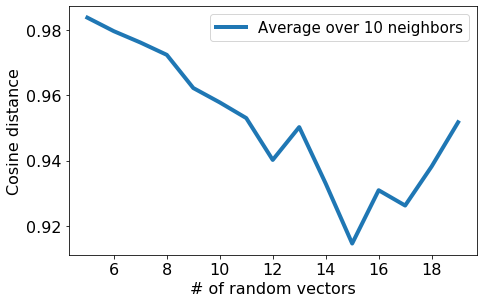

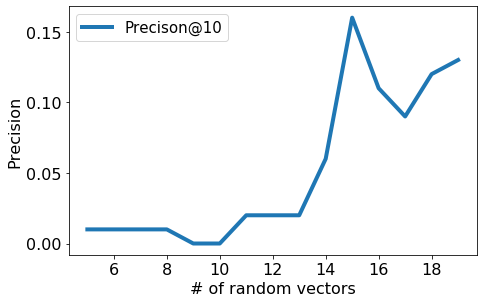

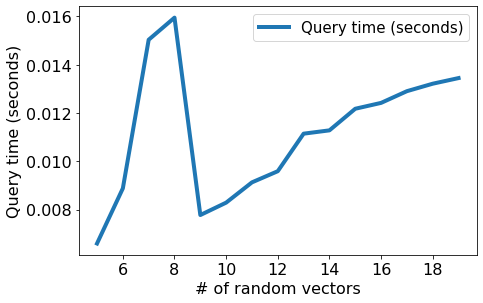

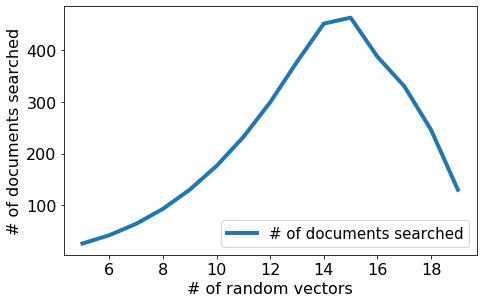

In [71]:
plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(average_distance[i]) for i in range(5,20)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('# of random vectors')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(precision[i]) for i in range(5,20)], linewidth=4, label='Precison@10')
plt.xlabel('# of random vectors')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(query_time[i]) for i in range(5,20)], linewidth=4, label='Query time (seconds)')
plt.xlabel('# of random vectors')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(num_candidates_history[i]) for i in range(5,20)], linewidth=4,
         label='# of documents searched')
plt.xlabel('# of random vectors')
plt.ylabel('# of documents searched')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

We see a similar trade-off between quality and performance: as the number of random vectors increases, the query time goes down as each bin contains fewer documents on average, but on average the neighbors are likewise placed farther from the query. On the other hand, when using a small enough number of random vectors, LSH becomes very similar brute-force search: Many documents appear in a single bin, so searching the query bin alone covers a lot of the corpus; then, including neighboring bins might result in searching all documents, just as in the brute-force approach.